In [1]:
from pcnn.parameters import parameters
from pcnn.util import load_data, initialize_heat_gains_from_heating_cooling, \
    initialize_heat_losses_to_outside, initialize_heat_losses_to_neighbors
from pcnn.model import Model

# Load data, define interval
data = load_data('umar')
display(data.head())

,Solar irradiation,Outside temperature,Temperature 272,Temperature 273,Temperature 274,Month sin,Month cos,Weekday,Timestep sin,Timestep cos,Power 272,Power 273,Power 274,Case
2019-05-01 00:00:00,0.0,7.877023,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.000000,1.000000,0.0,0.0,0.0,1.0
2019-05-01 00:15:00,0.0,7.631382,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.065403,0.997859,0.0,0.0,0.0,1.0
2019-05-01 00:30:00,0.0,7.527863,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.130526,0.991445,0.0,0.0,0.0,1.0
2019-05-01 00:45:00,0.0,7.343938,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.195090,0.980785,0.0,0.0,0.0,1.0
2019-05-01 01:00:00,0.0,7.193133,22.2047,24.4094,23.7795,0.5,-0.866025,2,0.258819,0.965926,0.0,0.0,0.0,1.0


In [2]:
## Data parameters
data_params = dict(temperature_column='Temperature 272',
                   power_column='Power 272',  # same order as the temperature columns above!
                   case_column='Case',
                   out_column='Outside temperature',
                   neigh_column='Temperature 273', 
                   inputs_D=['Solar irradiation', 'Month sin', 'Month cos', 'Weekday', 'Timestep sin', 'Timestep cos'],
                   outside_walls=None, # There is only one room, and it has an external wall
                   neighboring_rooms=None, # Not needed in PCNNs - None tells the model it is a single-zone PCNN
                   seed=0) # To mix training, validation and testing data

In [3]:
## Physical parameter initialization
# This is an approximation, you can define your own values
# If you do so,  you only need to be careful about the impact of normalization on the temperature output of the model 
# (which predicts values between 0.1 and 0.9 and not in the original data range)

# Parameters needed for correct initialization due to data normalization and discretization
params = dict(min_temperature=data.min()[data_params['temperature_column']],
              max_temperature=data.max()[data_params['temperature_column']],
              interval_minutes=15)

initial_value_a = initialize_heat_gains_from_heating_cooling(temperature_difference=2, # How many degrees are gained/or lost when heating or cooling (typically at night when the sun doesn't shine to avoid these heat gains) 
                                                             power=data.max()[data_params['power_column']], # Power input at that time (here, at full power)
                                                             time_elapsed_hours=4, # Time needed to observe the temperature difference
                                                             parameters=params)

initial_value_b = initialize_heat_losses_to_outside(temperature_difference=1.5, # How many degrees are lost (typically at night when heating/cooling is off and the sun doesn't shine to avoid these heat gains) 
                                                    temperature_difference_to_outsie=25, # Temperature gradient with the outside or neighboring thermal zone
                                                    time_elapsed_hours=6, # Time needed to observe the temperature difference
                                                    parameters=params)

initial_value_c = initialize_heat_losses_to_neighbors(temperature_difference=1.5,  # How many degrees are lost (typically at night when heating/cooling is off and the sun doesn't shine to avoid these heat gains) 
                                                      temperature_difference_to_neighbors=2.5, # Temperature gradient with the outside or neighboring thermal zone
                                                      time_elapsed_hours=6, # Time needed to observe the temperature difference
                                                      neighboring_rooms=data_params['neighboring_rooms'], # Pairs of neighboring rooms to initialize c
                                                      parameters=params)

initial_value_d = initialize_heat_gains_from_heating_cooling(temperature_difference=2, # How many degrees are gained/or lost when heating or cooling (typically at night when the sun doesn't shine to avoid these heat gains) 
                                                             power=data.max()[data_params['power_column']], # Power input at that time (here, at full power)
                                                             time_elapsed_hours=4, # Time needed to observe the temperature difference
                                                             parameters=params)

In [4]:
model_params = parameters(name="PCNNL",
                            seed=0,
                            overlapping_distance=4,
                            warm_start_length=12,
                            maximum_sequence_length=96*3,
                            minimum_sequence_length=48,
                            learn_initial_hidden_states=True,
                            decrease_learning_rate=False,
                            learning_rate=0.0005,
                            feed_input_through_nn=True,
                            input_nn_hidden_sizes=[32],
                            lstm_hidden_size=64,
                            lstm_num_layers=2,
                            layer_norm=True,
                            batch_size=256,
                            output_nn_hidden_sizes=[32],
                            division_factor=10.,
                            device='cpu',
                            verbose=2)

model_params['initial_values_physical_parameters'] = dict(a=initial_value_a,
                                                          b=initial_value_b,
                                                          c=initial_value_c,
                                                          d=initial_value_d)

# What model to use (PCNN, S_PCNN, M_PCNN, LSTM)
module = 'PCNN'

# Trying to load a model or not, if yes the last one or the best one
load = True
load_last = True

pcnn = Model(data=data, module=module, model_params=model_params, data_params=data_params,
             load=load, load_last=load_last)

2025-03-21 11:51:46.667 | INFO     | pcnn.data:__init__:12 - Preparing the data...
2025-03-21 11:51:46.669 | INFO     | pcnn.data:check_columns:102 - Sanity check of the columns:
[('Case', ['Case']), ('Room temp', ['Temperature 272']), ('Room power', ['Power 272']), ('Out temp', ['Outside temperature']), ('Neigh temp', ['Temperature 273'])]
2025-03-21 11:51:46.670 | INFO     | pcnn.data:check_columns:107 - Inputs used in D:
['Solar irradiation' 'Month sin' 'Month cos' 'Weekday' 'Timestep sin'
 'Timestep cos']
2025-03-21 11:51:46.670 | INFO     | pcnn.data:__init__:46 - Normalizing the data...
2025-03-21 11:51:46.685 | INFO     | pcnn.data:prepare_data:226 - Data ready!

2025-03-21 11:51:47.124 | INFO     | pcnn.model:load:877 - Trying to load a trained model...
2025-03-21 11:51:47.148 | INFO     | pcnn.model:load:927 - Found! It contains 10029 training, 1273 validation, and 1265 test sequences.
2025-03-21 11:51:47.148 | INFO     | pcnn.model:load:929 - The model has been fitted for 100

In [5]:
train = False
if train:
    pcnn.fit(100)

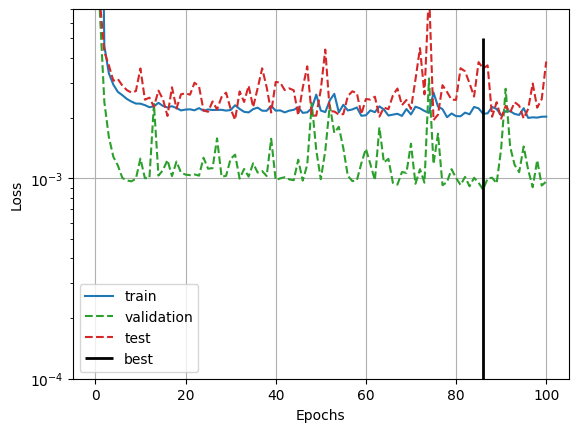

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(pcnn.train_losses, c='tab:blue', label='train')
plt.plot(pcnn.validation_losses, c='tab:green', ls='--', label='validation')
plt.plot(pcnn.test_losses, c='tab:red', ls='--', label='test')
plt.vlines(x=np.argmin(pcnn.validation_losses), ymin=1e-4, ymax=5e-3, color='black', lw=2, label='best')
#plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(1e-4, 7e-3)
plt.yscale('log')
plt.legend()
plt.grid()

In [7]:
load_last = False

pcnn = Model(data=data, module=module, model_params=model_params, data_params=data_params,
             load=load, load_last=load_last)

2025-03-21 11:51:47.468 | INFO     | pcnn.data:__init__:12 - Preparing the data...
2025-03-21 11:51:47.472 | INFO     | pcnn.data:check_columns:102 - Sanity check of the columns:
[('Case', ['Case']), ('Room temp', ['Temperature 272']), ('Room power', ['Power 272']), ('Out temp', ['Outside temperature']), ('Neigh temp', ['Temperature 273'])]
2025-03-21 11:51:47.473 | INFO     | pcnn.data:check_columns:107 - Inputs used in D:
['Solar irradiation' 'Month sin' 'Month cos' 'Weekday' 'Timestep sin'
 'Timestep cos']
2025-03-21 11:51:47.473 | INFO     | pcnn.data:__init__:46 - Normalizing the data...
2025-03-21 11:51:47.488 | INFO     | pcnn.data:prepare_data:226 - Data ready!

2025-03-21 11:51:47.491 | INFO     | pcnn.model:load:877 - Trying to load a trained model...
2025-03-21 11:51:47.514 | INFO     | pcnn.model:load:927 - Found! It contains 10029 training, 1273 validation, and 1265 test sequences.
2025-03-21 11:51:47.514 | INFO     | pcnn.model:load:931 - The model achieved its best perfo

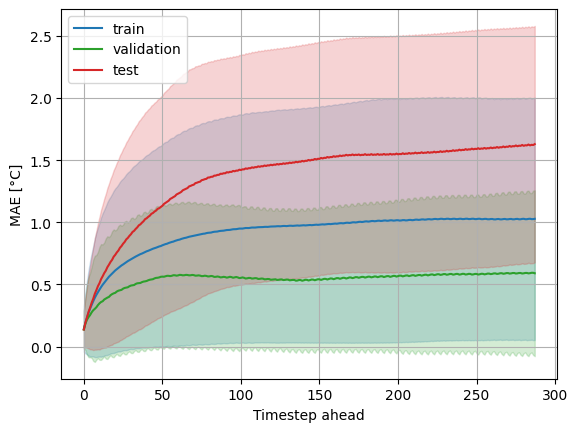

In [8]:
# Get predictions of the model and plot them
# 'predict_temperature' scales the data back to the original values
preds, true = pcnn.predict_temperature(sequences=pcnn.train_sequences)
time = np.arange(preds.shape[1] - pcnn.warm_start_length)
mean = np.nanmean(np.abs(preds - true)[:,pcnn.warm_start_length:,0], axis=0)
std = np.nanstd(np.abs(preds - true)[:,pcnn.warm_start_length:,0], axis=0)
plt.fill_between(time, mean-std, mean+std, alpha=0.2, color='tab:blue')
plt.plot(mean, color='tab:blue', label='train')

preds, true = pcnn.predict_temperature(sequences=pcnn.validation_sequences)
mean = np.nanmean(np.abs(preds - true)[:,pcnn.warm_start_length:,0], axis=0)
std = np.nanstd(np.abs(preds - true)[:,pcnn.warm_start_length:,0], axis=0)
plt.fill_between(time, mean-std, mean+std, alpha=0.2, color='tab:green')
plt.plot(mean, color='tab:green', label='validation')

preds, true = pcnn.predict_temperature(sequences=pcnn.test_sequences)
mean = np.nanmean(np.abs(preds - true)[:,pcnn.warm_start_length:,0], axis=0)
std = np.nanstd(np.abs(preds - true)[:,pcnn.warm_start_length:,0], axis=0)
plt.fill_between(time, mean-std, mean+std, alpha=0.2, color='tab:red')
plt.plot(mean, color='tab:red', label='test')

plt.xlabel('Timestep ahead')
plt.ylabel('MAE [\u00B0C]')
plt.legend()
plt.grid()
plt.show()